## Data Augmentation

Check these out later: https://www.tutorialspoint.com/natural_language_toolkit/natural_language_toolkit_synonym_antonym_replacement.htm, https://www.kaggle.com/code/rohitsingh9990/data-augmentation-by-synonym-replacement

In [1]:
import pandas as pd
import numpy as np
import os


DATA_PATH = os.path.join("..", "data")

In [2]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_essays.csv"))
train_df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [3]:
train_df[train_df.generated == 1]

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [4]:
def read_gpt(file: str) -> pd.Series:
    with open(os.path.join(DATA_PATH, file), encoding="utf8") as f:
        contents = f.read()
    responses = list(filter(lambda x: x.startswith(" ChatGPT"), 
                        contents.split("##")))
    clear_responses = [res.replace("ChatGPT", "").replace("~", "").strip() 
                            for res in responses]
    return pd.Series(clear_responses)


chat_gpt_environment = read_gpt("chatgpt_cars.md")
envir_df = pd.DataFrame({"id": [str(id(text)) for text in chat_gpt_environment],
                         "text": chat_gpt_environment, 
                         "prompt_id": np.zeros_like(chat_gpt_environment),
                         "generated": np.ones_like(chat_gpt_environment)})

chat_gpt_electoral = read_gpt("chatgpt_electoral.md")
elect_df = pd.DataFrame({"id": [str(id(text)) for text in chat_gpt_electoral],
                         "text": chat_gpt_electoral, 
                         "prompt_id": np.ones_like(chat_gpt_electoral),
                         "generated": np.ones_like(chat_gpt_electoral)})

df = pd.concat([envir_df, elect_df, train_df])
df

,id,text,prompt_id,generated
0,2593199512784,"In recent years, there has been a growing glob...",0,1
1,2593199516656,The advantages of limiting car usage are evide...,0,1
2,2593199241024,The global movement towards limiting car usage...,0,1
3,2593194962272,The advantages of limiting car usage are becom...,0,1
4,2593199244864,The advantages of limiting car usage are manif...,0,1
...,...,...,...,...
1373,fe6ff9a5,There has been a fuss about the Elector Colleg...,1,0
1374,ff669174,Limiting car usage has many advantages. Such a...,0,0
1375,ffa247e0,There's a new trend that has been developing f...,0,0
1376,ffc237e9,As we all know cars are a big part of our soci...,0,0


In [6]:
df.text.loc[df.text.apply(lambda x: x.startswith("Dear"))].iloc[3]

'Dear Senator,\n\nI am writing to express my support for retaining the Electoral College as the method for electing the President of the United States. While critics argue for its abolition, citing concerns about fairness and potential issues, it is crucial to consider the nuanced advantages highlighted by various sources, including the Office of the Federal Register and Judge Richard A. Posner.\n\nThe Electoral College, as explained by the Federal Register, was established as a compromise between direct congressional election and a popular vote, ensuring a balanced representation of federal and state interests (Federal Register, 1). This compromise remains relevant today, preventing the domination of densely populated areas and fostering a more inclusive system.\n\nCritics, such as Bradford Plumer, point out flaws in the Electoral College, emphasizing the potential for elector confusion and the so-called "disaster factor" (Plumer, 10-11). However, Judge Posner provides a more balanced

In [7]:
import re


bracket_regex = r"\[.*?\]"

df.text = df.text.apply(lambda x: re.sub(bracket_regex, "", x))
df.text = df.text.apply(lambda x: x.lower())

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections.abc import Iterable


# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
def remove_stopwords(words: str, stopwords: Iterable[str]) -> str:
    word_tokens = word_tokenize(words)
    # converts the words in word_tokens to lower case and then checks whether 
    #they are present in stop_words or not
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    #with no lower case conversion
    filtered_sentence = []
     
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)


stop_words = set(stopwords.words('english'))
df.text = df.text.apply(lambda x: remove_stopwords(x, stop_words))

In [9]:
df.text.loc[df.text.apply(lambda x: x.startswith("dear"))].iloc[3]

"dear senator , writing express support retaining electoral college method electing president united states . critics argue abolition , citing concerns fairness potential issues , crucial consider nuanced advantages highlighted various sources , including office federal register judge richard a. posner . electoral college , explained federal register , established compromise direct congressional election popular vote , ensuring balanced representation federal state interests ( federal register , 1 ) . compromise remains relevant today , preventing domination densely populated areas fostering inclusive system . critics , bradford plumer , point flaws electoral college , emphasizing potential elector confusion so-called `` disaster factor '' ( plumer , 10-11 ) . however , judge posner provides balanced perspective , outlining practical reasons retaining electoral college , including certainty outcome avoidance runoff elections ( posner , 18 , 22 ) . certainty outcome , argued posner , cr

In [10]:
(df.generated == 1).sum()

312

In [11]:
df.isnull().values.any()

False

In [12]:
df.dtypes

id           object
text         object
prompt_id    object
generated    object
dtype: object

In [13]:
df.prompt_id = df.prompt_id.astype(int)
df.generated = df.generated.astype(int)
df.dtypes

id           object
text         object
prompt_id     int32
generated     int32
dtype: object

## Classifiers

In [14]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(df,
                                         train_size=0.7, 
                                         test_size=0.3, 
                                         stratify=df.generated,
                                         random_state=42)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.generated.values
x_test = vectorizer.transform(data_test.text)
y_test = data_test.generated.values

The metric we will be using is Macro-F1 average.

- **F1** is a metric used to balance the need for making sure our classifications for a category are both correct (precision) and represent as many of the actual cases of the category as possible (recall).
- **Macro-F1** is the unweighted average of all F1 metrics for each class. We choose Macro F1 instead of a weighted average because we have an unbalanced dataset (Generated essays data are a small fraction of overall essays)


Thus, we want to use a metric which favors both thorough and precise classifiers, and which also assigns equal importance to our smaller classes.

In [16]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    """
    Minor utility method, wraping cross_val_score.
    """
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res.mean(), res.std()

### Dummy Classifier

We will first run a "fake" classifier which only guesses the majority category.

This dummy model thus completely disregards the input features and serves as a useful baseline with which to compare the subsequent classifiers.

In [17]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier


majority_model = DummyClassifier(strategy="most_frequent")
res = cross_val_res(majority_model, x_train, y_train)
print(f"Dummy Classifier mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Dummy Classifier mean macro F1-score 0.4491, std: 0.0010


### Naive Bayes

Naive Bayes is a very cheap and easy-to-interpret classifier, which checks for the probability that each individual word in the text will belong in any language. We generally want to use the simplest model for the job, and so we start with this reliable model which has proven itself in many fields in the past.

The `sklearn` library gives us access to many variations of Naive Bayes, each specialized in its own field. For this NLP task, we will be using `MultinomialNB`, which was suggested by [this blogpost](https://towardsdatascience.com/naive-bayes-classifiers-for-text-classification-be0d133d35ba).

In [18]:
from sklearn.naive_bayes import MultinomialNB


# naive bayes needs dense arrays to work 
naive_x_train = x_train.toarray()
naive_x_test = x_test.toarray()

naive_model = MultinomialNB()
res = cross_val_res(naive_model, naive_x_train, y_train)
print(f"Naive Bayes mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Naive Bayes mean macro F1-score 0.9627, std: 0.0197


In [19]:
naive_model = MultinomialNB().fit(x_train, y_train)
naive_res = naive_model.predict(x_test)
print(classification_report(y_test, naive_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       413
           1       1.00      0.93      0.96        94

    accuracy                           0.99       507
   macro avg       0.99      0.96      0.98       507
weighted avg       0.99      0.99      0.99       507



### Logistic Regression

LogisticRegression despite its name is a linear classifier, meaning that it attempts to linearly separate the data into distinct categories. This interpretation does not apply well to a NLP task, but means that the classifier retains some very useful properties:

- The solution we get is a global optimum, meaning that it's the best we can get with the provided data. This means no hyper-parameter tuning is necessary and we can use the classifier as-is.
- It's a simple and very easy to compute classifier, since it solves a (mathematically simple) linear problem, albeit with some restrictions (technically those restrictions force it to use gradient descent, but the calculations are much easier than say, a neural network)

In [20]:
from sklearn.linear_model import LogisticRegression
import warnings


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.9780, std: 0.0165


In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

print(classification_report(y_test, lr_res, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       413
           1       1.00      0.96      0.98        94

    accuracy                           0.99       507
   macro avg       1.00      0.98      0.99       507
weighted avg       0.99      0.99      0.99       507



### Random Forest

Random Forest is an ensemble algorithm, which means it uses many simpler algorithms which then "vote" on a final decision. It has proven to be a good classifier on complex tasks, it combats overfitting by design (essentially by utilizing random chance in its training phase) and is still fairly easy to interpret.

The drawback is first and foremost computational, since we need to train many smaller classifiers, which may by themselves be computationally expensive (this is somewhat offset by the fact that the classifiers are indepednent and can be computed in parallel). Additionally, Random Forest is a non-parametric method which means that it is generally memory-intensive and may be slow to run on operational data. Finally, we also need to tune hyperparameters.

In [22]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50,
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=5)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9856, std: 0.0102


In [23]:
forest_model = RandomForestClassifier(n_estimators=50, 
                                      criterion="entropy").fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
print(classification_report(y_test, forest_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.98      0.99        94

    accuracy                           1.00       507
   macro avg       1.00      0.99      0.99       507
weighted avg       1.00      1.00      1.00       507



### Adaboost

Adaboost is the logical conclusion of Random Forests, where each voter considers a very specific "rule" that needs to be followed. The next voter then considers the most important rule to distinguish between the categories for all the clases that the first could not reliably classify, and so on.

This classifier is generally more compact and competent than a simple Random Forest, but is more computationally expensive during training because we cannot train it in parallel.

In [24]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=25)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.9958, std: 0.0034


In [25]:
ada_model = AdaBoostClassifier(n_estimators=25).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
print(classification_report(y_test, ada_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       413
           1       1.00      0.98      0.99        94

    accuracy                           1.00       507
   macro avg       1.00      0.99      0.99       507
weighted avg       1.00      1.00      1.00       507



In [26]:
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


best_model = forest_model
best_pred = best_model.predict(x_test)
c = make_pipeline(vectorizer, best_model)
explainer = LimeTextExplainer(class_names=forest_model.classes_)

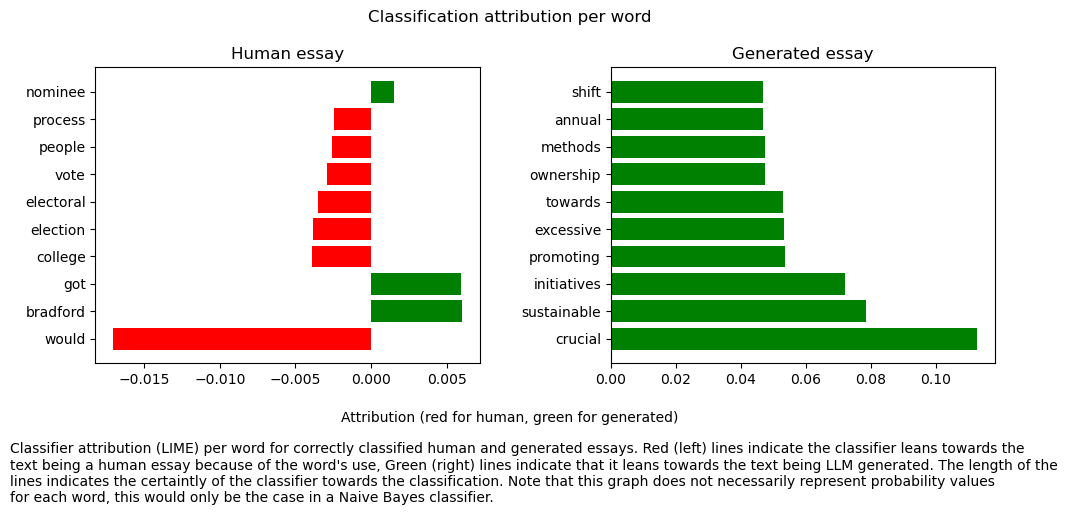

In [27]:
import matplotlib.pyplot as plt
import textwrap


# code for lime text and graph attributed to Ioannis Pavlopoulos
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# explanation for (correct) human classification
example_human = data_test[(data_test.generated == 0) & (best_pred == 0)].sample(1)
exp_human = explainer.explain_instance(example_human.text.iloc[0] , c.predict_proba)
exp_human_reversed = [(name, -value) for name, value in exp_human.as_list()]
word_scores_human = pd.DataFrame(exp_human.as_list(), columns=["word", "xscore"]) 
word_scores_human['color'] = word_scores_human.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[0].barh(word_scores_human.word, word_scores_human.xscore, color=word_scores_human.color)
axes[0].set_title("Human essay")

# explanation for generated classification
example = data_test[(data_test.generated == 1) & (best_pred == 1)].sample(1)
exp = explainer.explain_instance(example.text.iloc[0] , c.predict_proba)
word_scores = pd.DataFrame(exp.as_list(), columns=["word", "xscore"])
word_scores['color'] = word_scores.xscore.apply(lambda x: 'g' if x>0 else 'r')

axes[1].barh(word_scores.word, word_scores.xscore, color=word_scores.color)
axes[1].set_title("Generated essay")

caption_text = "Classifier attribution (LIME) per word for correctly classified human and generated essays. "\
                "Red (left) lines indicate the classifier leans towards the text being a human essay "\
                "because of the word's use, Green (right) lines indicate that it leans towards the text being LLM generated. "\
                "The length of the lines indicates the certaintly of the classifier towards the classification. "\
                "Note that this graph does not necessarily represent probability values for each word."

caption = textwrap.fill(caption_text, width=150)
fig.text(0, -0.25, caption)

fig.suptitle("Classification attribution per word")
fig.text(0.5, -0.05, 'Attribution (red for human, green for generated)', ha='center')
fig.tight_layout(h_pad=3, w_pad=3) #believe it or not this *is* different from pad=3
plt.show()

## Text Similarity

https://www.newscatcherapi.com/blog/ultimate-guide-to-text-similarity-with-python

In [28]:
print("Downloading Word2Vec model...")

In [29]:
%%capture
!python -m spacy download en_core_web_md

In [30]:
print("Model downloaded.")

Model downloaded.


In [31]:
import spacy


print("Loading Word2Vec model...")
word2vec = spacy.load('en_core_web_md')
print("Model loaded.")

Loading Word2Vec model...
Model loaded.


In [32]:
from tqdm import tqdm


generated_df = df[df.generated == 1]
human_df = df[df.generated == 0]

generated_docs = []
human_docs = []

print("Computing embeddings for generated essays...")
for text in tqdm(generated_df.text):
    generated_docs.append(word2vec(text))
print("Done.")

print("Computing embeddings for human essays...")
for text in tqdm(human_df.text):
    human_docs.append(word2vec(text))
print("Done.")

Computing embeddings for generated essays...


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [00:22<00:00, 14.13it/s]


Done.
Computing embeddings for human essays...


100%|██████████████████████████████████████████████████████████████████████████████| 1375/1375 [01:42<00:00, 13.44it/s]

Done.


In [33]:
mean_similarity = []
max_similarity = []

print("Calculating similarity scores...")
for gen_doc in tqdm(generated_docs):
    similarities = []
    for human_doc in human_docs:
      similarities.append(gen_doc.similarity(human_doc))
        
    mean_similarity.append(np.mean(similarities))
    max_similarity.append(np.max(similarities))

Calculating similarity scores...


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [00:07<00:00, 41.35it/s]


In [34]:
similarity_df = pd.DataFrame({"id": generated_df.id,
                              "text": generated_df.text,
                              "mean": mean_similarity,
                              "max": max_similarity})
similarity_df

,id,text,mean,max
0,2593199512784,"recent years , growing global movement limit c...",0.873956,0.972159
1,2593199516656,advantages limiting car usage evident various ...,0.878144,0.972569
2,2593199241024,global movement towards limiting car usage gai...,0.880153,0.975580
3,2593194962272,advantages limiting car usage becoming increas...,0.884278,0.977396
4,2593199244864,"advantages limiting car usage manifold , exten...",0.876774,0.972363
...,...,...,...,...
154,2593197022272,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492
155,2593198875424,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601


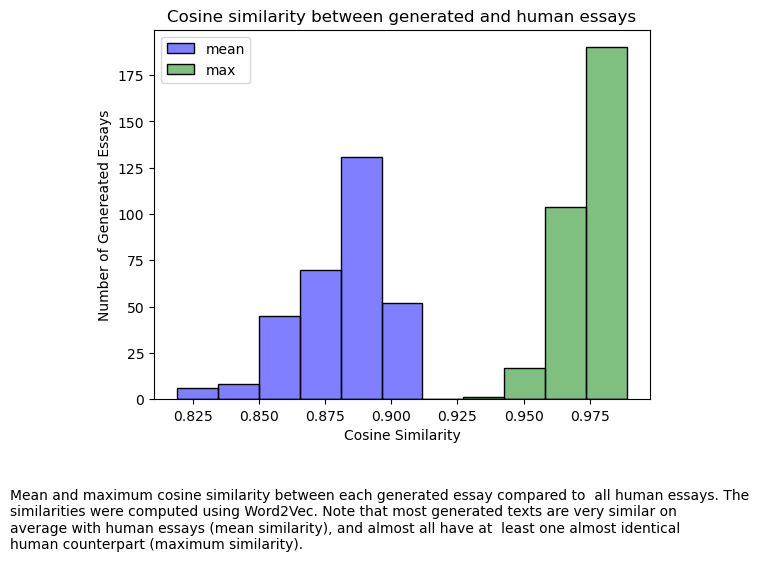

In [35]:
import seaborn as sns
import textwrap


sns.histplot(similarity_df, palette={"mean": "blue", "max": "green"})

caption_text = """Mean and maximum cosine similarity between each generated essay compared to 
all human essays. The similarities were computed using Word2Vec. Note that most generated texts
are very similar on average with human essays (mean similarity), and almost all have at 
least one almost identical human counterpart (maximum similarity).
"""
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.2, caption)

plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Genereated Essays")
plt.title("Cosine similarity between generated and human essays")
plt.show()

In [36]:
np.unique(similarity_df.id).shape

(312,)

In [37]:
probs = []

# TODO: look into this
print("Starting Leave One Out validation for generated texts...")
for essay_id in tqdm(similarity_df.id):
    essay_train = df[~df.id.eq(essay_id)] 
    essay_test = df[df.id.eq(essay_id)]
    assert essay_test.shape[0] == 1, essay_id
    model = RandomForestClassifier(n_estimators=25)
    model = model.fit(vectorizer.transform(essay_train.text), essay_train.generated)
    probs.append(model.predict_proba(vectorizer.transform(essay_test)))

Starting Leave One Out validation for generated texts...


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [11:46<00:00,  2.26s/it]


In [38]:
similarity_df["probs"] = [x[0][0] for x in probs]
similarity_df

,id,text,mean,max,probs
0,2593199512784,"recent years , growing global movement limit c...",0.873956,0.972159,1.0
1,2593199516656,advantages limiting car usage evident various ...,0.878144,0.972569,1.0
2,2593199241024,global movement towards limiting car usage gai...,0.880153,0.975580,1.0
3,2593194962272,advantages limiting car usage becoming increas...,0.884278,0.977396,1.0
4,2593199244864,"advantages limiting car usage manifold , exten...",0.876774,0.972363,1.0
...,...,...,...,...,...
154,2593197022272,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492,1.0
155,2593198875424,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813,1.0
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460,1.0
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601,1.0


In [39]:
similarity_df["probs"] = probs
similarity_df

,id,text,mean,max,probs
0,2593199512784,"recent years , growing global movement limit c...",0.873956,0.972159,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
1,2593199516656,advantages limiting car usage evident various ...,0.878144,0.972569,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
2,2593199241024,global movement towards limiting car usage gai...,0.880153,0.975580,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
3,2593194962272,advantages limiting car usage becoming increas...,0.884278,0.977396,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
4,2593199244864,"advantages limiting car usage manifold , exten...",0.876774,0.972363,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
...,...,...,...,...,...
154,2593197022272,"dear , hey , hope 're good ! , 've thinking lo...",0.878327,0.956492,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
155,2593198875424,"dear , hope letter finds chill . wanted throw ...",0.841934,0.928813,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
704,82131f68,"essay analyze , discuss prove one reason favor...",0.869092,0.985460,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"
740,86fe4f18,strongly believe electoral college remain way ...,0.818765,0.973601,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0]]"


## Impact of data size

In [40]:
len_splits = np.arange(start=0.1, stop=1.1, step=0.1)
splits = [data_train.sample(int(np.ceil(data_train.shape[0]*i))) for i in len_splits]

sizes = [len(split) for split in splits]
sizes

[118, 236, 355, 472, 590, 708, 827, 944, 1062, 1180]

In [41]:
from sklearn.metrics import f1_score


train_scores = []
test_scores = []

for split in splits:
    x_train = vectorizer.transform(split.text)
    y_train = split.generated
    model = RandomForestClassifier(n_estimators=50).fit(x_train, y_train)

    train_preds = model.predict(x_train)
    train_scores.append(f1_score(y_train, train_preds, average="macro"))
    test_preds = model.predict(x_test)
    test_scores.append(f1_score(y_test, test_preds, average="macro"))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

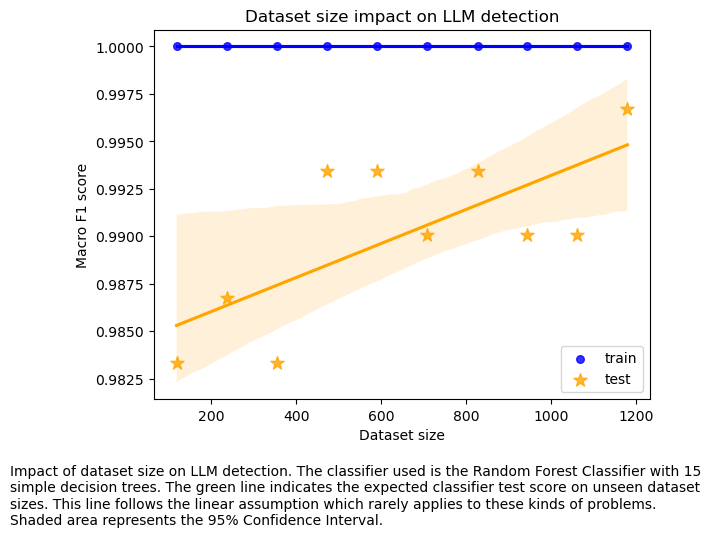

In [42]:
sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            scatter_kws={"s": 30})
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            scatter_kws={"s": 100})

plt.title("Dataset size impact on LLM detection")
plt.ylabel("Macro F1 score")
plt.xlabel("Dataset size")
#plt.ylim(None, 1.1)

# TODO: come back to this once done with data and classifiers
caption_text = "Impact of dataset size on LLM detection. The classifier used is the "\
"Random Forest Classifier with 15 simple decision trees. The green line indicates "\
"the expected classifier test score on unseen dataset sizes. This line follows the "\
"linear assumption which rarely applies to these kinds of problems. Shaded area represents "\
"the 95% Confidence Interval."
caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.15, caption)

plt.legend()
plt.show()

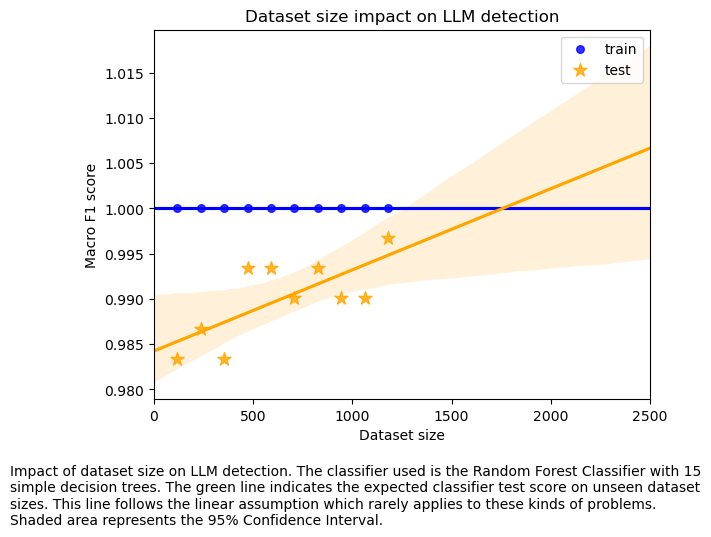

In [43]:
plt.xlim(0, 2500)

sns.regplot(y=train_scores, 
            x=sizes, 
            label="train", 
            color="blue", 
            scatter_kws={"s": 30},
            truncate=False)
sns.regplot(y=test_scores,
            x=sizes,
            label="test",
            color="orange",
            marker="*", 
            scatter_kws={"s": 100},
            truncate=False)

plt.title("Dataset size impact on LLM detection")
plt.ylabel("Macro F1 score")
plt.xlabel("Dataset size")

caption = textwrap.fill(caption_text, width=100)
plt.figtext(-0.1, -0.15, caption)

plt.legend()
plt.show()

## Clustering-based augmentation

https://builtin.com/data-science/elbow-method

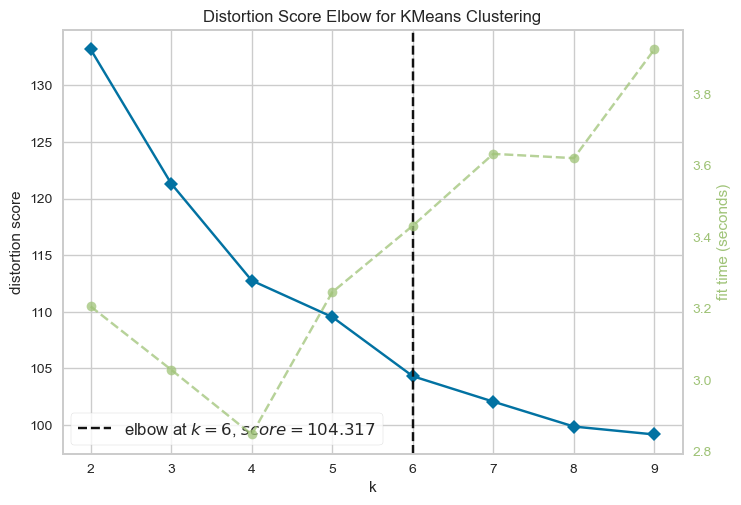

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

generated_train_df = data_train[data_train.generated == 1].copy()
generated_train = vectorizer.transform(generated_train_df.text).toarray()


# there is an internal memory leak here, don't worry about it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    km = KMeans(random_state=42, n_init=5)
    visualizer = KElbowVisualizer(km, k=(2,10))
    visualizer.fit(generated_train)        
    
visualizer.show()        

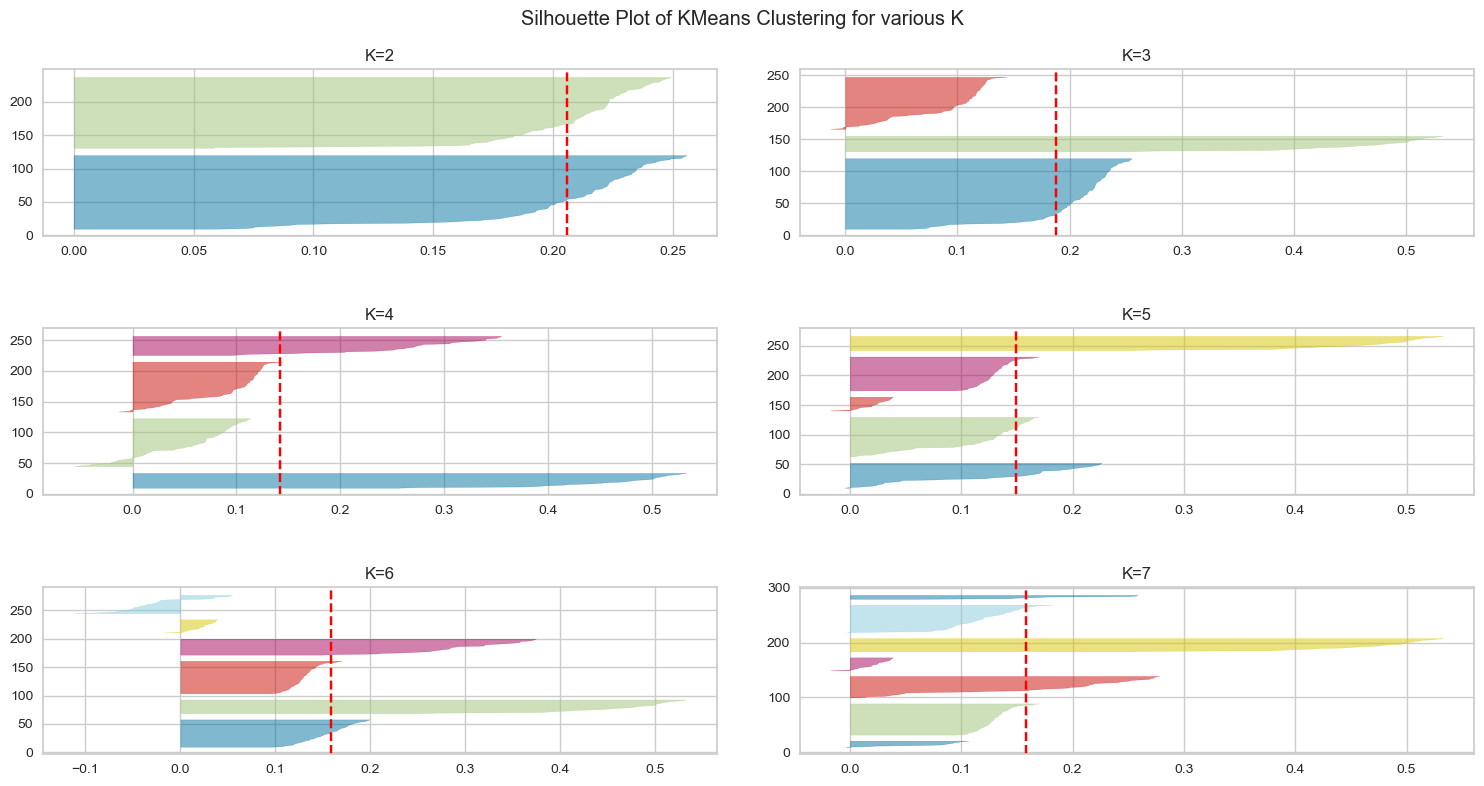

In [45]:
from yellowbrick.cluster import SilhouetteVisualizer


fig, axes = plt.subplots(3, 2, figsize=(15,8))

for i in range(2, 8):
    # there is an internal memory leak here, don't worry about it
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        km = KMeans(n_clusters=i, init='k-means++', n_init=5, random_state=42)
        
        q, mod = divmod(i, 2)
        ax = axes[q-1][mod]
        ax.set_title(f"K={i}")
        
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(generated_train) 

fig.suptitle("Silhouette Plot of KMeans Clustering for various K")
fig.tight_layout(h_pad=3, w_pad=3)
#visualizer.show() 

In [46]:
km = KMeans(n_clusters=2, init="k-means++", random_state=42, n_init=10)
preds = km.fit_predict(generated_train)
generated_train_df["cluster"] = preds

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


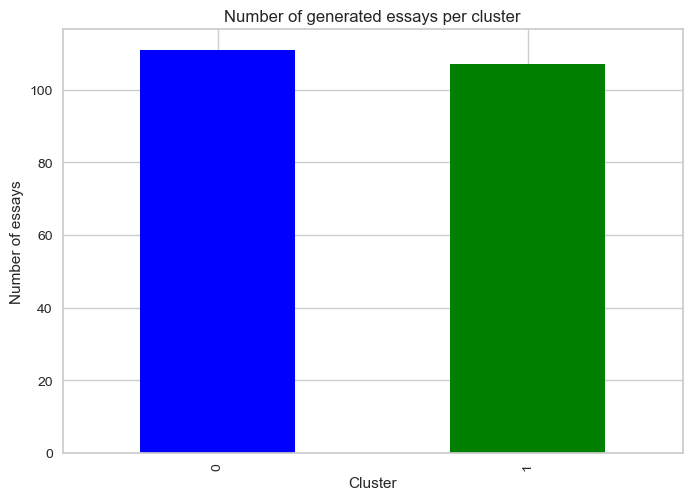

In [47]:
ax = generated_train_df.cluster.value_counts().sort_index().plot(
    kind='bar', 
    color=['blue', 'green', 'red', 'purple'])
ax.set_title("Number of generated essays per cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of essays")

plt.show()

In [48]:
for cluster in np.unique(generated_train_df.cluster):
    print("=" * 100)
    print(f"Cluster {cluster}")
    for text in generated_train_df[generated_train_df.cluster==1].sample(3).text:
        print("\t\t", text)

Cluster 0
		 modern urban environment , proposition limit car usage emerges strategic imperative , offering spectrum advantages individuals communities . essay synthesizes insights diverse sources , including world health organization ( ) , international energy agency ( iea ) , american automobile association ( aaa ) , aiming inform fellow citizens diverse benefits associated reducing dependence cars . primary advantage limiting car usage positive impact environmental health , concern underscored . vehicular emissions , major contributor air pollution , identified significant public health hazards . studies demonstrate restricting car usage substantially decrease harmful emissions , leading improved air quality reduced health risks . instances cities like london singapore , effective car restrictions implemented , serve tangible evidence positive correlation limiting car usage improvements air quality , ultimately promoting public health well-being . moreover , transition sustainable t